In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
!wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!apt-get install -f
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
--2019-04-23 14:07:27--  https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
Resolving launchpad.net (launchpad.net)... 91.189.89.222, 91.189.89.223, 2001:67c:1560:8003::8003, ...
Connecting to launchpad.net (launchpad.net)|91.189.89.222|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2019-04-23 14:07:27 ERROR 404: Not Found.

dpkg: error: cannot access archive 'google-drive-ocaml

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
!pip install tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 48kB/s 
    100% |████████████████████████████████| 61kB 25.3MB/s 
    100% |████████████████████████████████| 3.0MB 9.8MB/s 
    100% |████████████████████████████████| 419kB 6.2MB/s 


In [0]:
import cv2
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from sklearn.datasets import load_files
import matplotlib.pyplot as plt

In [0]:
def load_data(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    return files

In [0]:
def ext_img(img):
    imag = cv2.imread(img)
    imag = cv2.cvtColor(imag,cv2.COLOR_BGR2GRAY)
    imag = imag/255
    imag = np.expand_dims(imag,axis=2)
    return imag

In [0]:
def tensor_4d(fil):
    lis = [ext_img(im) for im in tqdm(fil)]
    return np.stack(lis,axis=0)

In [0]:
fold_path = 'drive/datasets/shapes'

In [0]:
img_files = load_data(fold_path)

In [10]:
imgs = tensor_4d(img_files)

100%|██████████| 300/300 [00:01<00:00, 211.54it/s]


In [11]:
imgs.shape

(300, 28, 28, 1)

In [0]:
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv8 = tf.keras.layers.Conv2D(8,3,activation=tf.nn.relu,strides=(1,1),padding='SAME')
        self.conv16 = tf.keras.layers.Conv2D(16,3,activation=tf.nn.relu,strides=(1,1),padding='SAME')
        self.conv32 = tf.keras.layers.Conv2D(32,3,activation=tf.nn.relu,strides=(1,1),padding='SAME')
        self.max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))
        self.max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))
        
    def call(self,inp):
        x = self.conv32(inp)
        x = self.max_pool_1(x)
        x = self.conv16(x)
        x = self.max_pool_2(x)
        x = self.conv8(x)
        return x
        
        
        

In [0]:
class Decoder(tf.keras.layers.Layer):
    
    def __init__(self):
        super(Decoder,self).__init__()
        self.convtr8 = tf.keras.layers.Conv2DTranspose(8,3,strides=(1,1),padding='SAME',activation=tf.nn.relu)
        self.convtr16 = tf.keras.layers.Conv2DTranspose(16,3,strides=(1,1),padding='SAME',activation=tf.nn.relu)
        self.convtr32 = tf.keras.layers.Conv2DTranspose(32,3,strides=(1,1),padding='SAME',activation=tf.nn.relu)
        self.convtr1 = tf.keras.layers.Conv2DTranspose(1,3,strides=(1,1),padding='SAME',activation=tf.nn.relu)
        self.upsample_1 = tf.keras.layers.UpSampling2D(size=(2,2))
        self.upsample_2 = tf.keras.layers.UpSampling2D(size=(2,2))
        
    def call(self,inp):
        x = self.convtr8(inp)
        x = self.upsample_1(x)
        x = self.convtr16(x)
        x = self.upsample_2(x)
        x = self.convtr32(x)
        x = self.convtr1(x)
        return x
        

In [0]:
class Autoencoder(tf.keras.Model):
    
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encode = Encoder()
        self.decode = Decoder()
        
    def call(self,inputs):
        encoded = self.encode(inputs)
        decoded = self.decode(encoded)
        return decoded

In [0]:
ae = Autoencoder()
        

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

In [0]:
ae = Autoencoder()

In [43]:
for epoch in range(400):
    print('Start of epoch %d' % (epoch,))

    for start,end in zip(range(0,len(imgs),10),range(10,len(imgs),10)):
        xtr = imgs[start:end]
        xtr = xtr.astype('float32')
        noi = xtr + 0.5*np.random.randn(*xtr.shape)
        noi = np.clip(noi,0.,1.)
        with tf.GradientTape() as tape:
            recon = ae(noi)
            loss = mse_loss_fn(xtr, recon)

        grads = tape.gradient(loss, ae.trainable_variables)
        optimizer.apply_gradients(zip(grads, ae.trainable_variables))

        loss_metric(loss)

        if start % 100 == 0:
            print('step %s: mean loss = %s' % (start, loss_metric.result().numpy()))

Start of epoch 0
step 0: mean loss = 0.020298984
step 100: mean loss = 0.020284552
step 200: mean loss = 0.020266693
Start of epoch 1
step 0: mean loss = 0.020251129
step 100: mean loss = 0.020236045
step 200: mean loss = 0.020219589
Start of epoch 2
step 0: mean loss = 0.020205155
step 100: mean loss = 0.020190742
step 200: mean loss = 0.020174533
Start of epoch 3
step 0: mean loss = 0.020161161
step 100: mean loss = 0.02014642
step 200: mean loss = 0.020130903
Start of epoch 4
step 0: mean loss = 0.020117644
step 100: mean loss = 0.020102317
step 200: mean loss = 0.020087527
Start of epoch 5
step 0: mean loss = 0.02007372
step 100: mean loss = 0.020059902
step 200: mean loss = 0.02004338
Start of epoch 6
step 0: mean loss = 0.020030128
step 100: mean loss = 0.02001627
step 200: mean loss = 0.02000067
Start of epoch 7
step 0: mean loss = 0.0199869
step 100: mean loss = 0.019972553
step 200: mean loss = 0.019957287
Start of epoch 8
step 0: mean loss = 0.019943604
step 100: mean loss = 

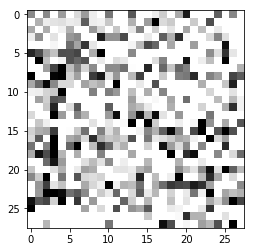

In [44]:
samp = imgs[0].astype('float32')
noi_p = samp + 0.5*np.random.randn(*samp.shape)
noi_p = np.clip(noi_p,0.,1.)
plt.imshow(np.squeeze(noi_p,axis=2),cmap='gray')
plt.show()



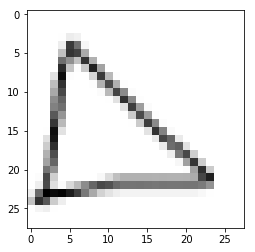

In [45]:
plt.imshow(np.squeeze(imgs[0],axis=2),cmap='gray')
plt.show()


In [46]:
noi_p = np.expand_dims(noi_p,axis=0)
noi_p.shape

(1, 28, 28, 1)

In [0]:
#noi_p = noi_p.astype('float32')
pred = ae(noi_p)

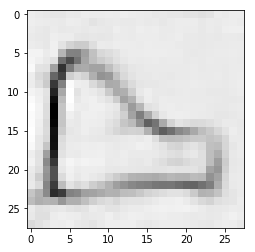

In [48]:
plt.imshow(np.squeeze(pred[0],axis=2),cmap='gray')
plt.show()